In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from tqdm import tqdm
import os 
from chainconsumer import ChainConsumer
from sbi_lens.config import config_lsst_y_10
import haiku as hk
from functools import partial
from sbi_lens.normflow.models import ConditionalRealNVP, AffineSigmoidCoupling
import numpyro.distributions as dist
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions
from haiku._src.nets.resnet import ResNet18
import pickle

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# plot params

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["lines.linewidth"] = 1
plt.rcParams['lines.markersize'] = 3
color = [
    '#FF8F00',
    '#FD5F00',
    '#00204A',
    '#005792',
    '#8AD5E6', 
    "#111111", 
    '#FD5F00'
]

In [2]:
# params

seed_store = [2,4,5,6,7,8,9]
n = 100_000
m = 10_000


dim = 6
n_flow_layers = 8
n_bijector_layers = 5
activ_fun = 'silu'
lr_schedule = 'exp_decay'
total_steps = 50_000

activ_fun_fn = jax.nn.silu
truth = config_lsst_y_10.truth
params_name = config_lsst_y_10.params_name_latex
N = config_lsst_y_10.N
nbins = config_lsst_y_10.nbins

In [4]:
# load all required data

dataset = np.load('./LOADED&COMPRESSED_year_10_with_noise_score_density.npz', allow_pickle=True)['arr_0']

m_data = jnp.load('./data/m_data__256N_10ms_27gpa_0.26se.npy')

a_file = open('./data/params_compressor/opt_state_resnet_vmim.pkl', "rb") 
opt_state_resnet= pickle.load(a_file)

a_file = open('./data/params_compressor/params_nd_compressor_vmim.pkl', "rb")
parameters_compressor= pickle.load(a_file)

metric_deep_ensemble = pd.read_table("./store_experiments.csv", ',')

sample_ff = jnp.load(
  './data/posterior_full_field__256N_10ms_27gpa_0.26se.npy', allow_pickle=True
)

sample_ps = jnp.load(
  './data/posterior_power_spectrum__256N_10ms_27gpa_0.26se.npy', allow_pickle=True
)

/tmp/ipykernel_226849/2570856186.py:13: FutureWarning: In a future version of pandas all arguments of read_table except for the argument 'filepath_or_buffer' will be keyword-only.
  metric_deep_ensemble = pd.read_table("./metric_deep_ensemble.csv", ',')


In [5]:
# compress observed data 

compressor = hk.transform_with_state(
    lambda y : ResNet18(dim)(y, is_training=False)
)

m_data_comressed, _ = compressor.apply(
  parameters_compressor,
  opt_state_resnet,
  None,
  m_data.reshape([1, N, N, nbins])
)

In [6]:
# NF architecture

key = jax.random.PRNGKey(0)

omega_c = dist.TruncatedNormal(0.2664, 0.2, low=0).sample(key, (1000,))
omega_b = dist.Normal(0.0492, 0.006).sample(key, (1000,))
sigma_8 = dist.Normal(0.831, 0.14).sample(key, (1000,))
h_0 = dist.Normal(0.6727, 0.063).sample(key, (1000,))
n_s = dist.Normal(0.9645, 0.08).sample(key, (1000,))
w_0 = dist.TruncatedNormal(-1.0, 0.9, low=-2.0, high=-0.3).sample(key, (1000,))

theta = jnp.stack([omega_c, omega_b, sigma_8, h_0, n_s, w_0], axis = -1)

scale_theta = (jnp.std(theta, axis = 0)/0.07)
shift_theta = jnp.mean(theta/scale_theta, axis = 0)-0.5

normalized_p = tfb.Chain([tfb.Scale(scale_theta),tfb.Shift(shift_theta)]).inverse(theta)


bijector_layers = [128] * n_bijector_layers

bijector_npe = partial(
    AffineSigmoidCoupling,
    layers=bijector_layers,
    activation=activ_fun_fn,
    n_components=16
  )

NF_npe = partial(
  ConditionalRealNVP,
  n_layers=n_flow_layers,
  bijector_fn=bijector_npe)

class SmoothNPE(hk.Module):
    def __call__(self, y):
        nvp = NF_npe(dim)(y)
        return tfd.TransformedDistribution(
            nvp,
            tfb.Chain([tfb.Scale(scale_theta), tfb.Shift(shift_theta)]))

log_prob_nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))

log_prob_fn = lambda params, theta, y : log_prob_nvp_nd.apply(params, theta, y)

prob_nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).prob(theta).squeeze()))

prob_fn = lambda params, theta, y : prob_nvp_nd.apply(params, theta, y)

nvp_sample_nd = hk.transform(
    lambda y : SmoothNPE()(y).sample(len(sample_ff), seed=hk.next_rng_key())
)

In [7]:
# functions for the NF mixture

@jax.jit
def compute_mean_log_likelihood(params, mu, batch):
    return jnp.mean(log_prob_fn(params, mu, batch))

def get_sample_from_DE(store_params, store_sample, theta,batch, n):
    likelihood_store = []
    
    for params in store_params:
        likelihood_store.append(
            compute_mean_log_likelihood(params, theta, batch)
        )
    likelihood_store = jnp.array(likelihood_store)
    likelihood_store_med = jnp.median(likelihood_store)
    likelihood_store = jax.nn.softplus(likelihood_store - likelihood_store_med)
    likelihood_sum = jnp.sum(likelihood_store)
    weight = likelihood_store / likelihood_sum
    
    cat_samples = tfd.Categorical(probs=weight).sample(n, seed=jax.random.PRNGKey(0))
    unique, counts = np.unique(cat_samples, return_counts=True)
    cat_dict = dict(zip(unique, counts))
    
    for j,i in enumerate(cat_dict):
        if j == 0:
            weighted_samples = jnp.array(store_sample)[i][:cat_dict[i]]
        else:
            weighted_samples = jnp.concatenate([
                    weighted_samples,
                    jnp.array(store_sample)[i][:cat_dict[i]]
                ], 
                axis = 0
            )
        
    return weighted_samples, weight, cat_dict

@jax.jit
def get_logprob_from_DE(store_params, theta, x, cat):
    
    distribution_log_probs = [
        log_prob_fn(params, theta.reshape([-1,dim]), x.reshape([-1,dim])) for params in store_params
    ]
    cat_log_probs = jax.nn.log_softmax(cat.logits_parameter())
    final_log_probs = [
        cat_lp + d_lp
        for (cat_lp, d_lp) in zip(cat_log_probs, distribution_log_probs)
    ]
    concat_log_probs = jnp.stack(final_log_probs, 0)
    log_sum_exp =tfp.math.reduce_weighted_logsumexp(concat_log_probs, axis=[0])
    return log_sum_exp

negative log prob:  26.63633


<Figure size 1500x800 with 0 Axes>

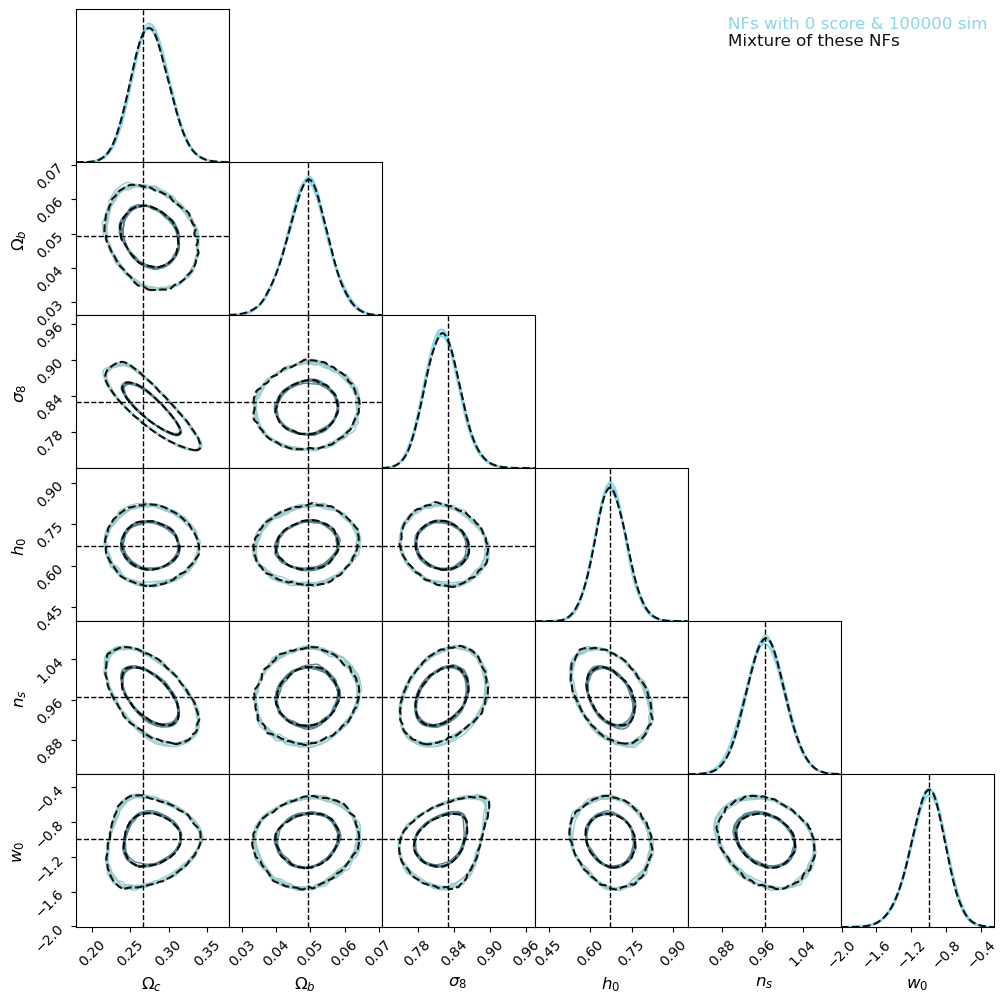

In [26]:
#  reference NF
score = 0
nb_sim = 100_000

plt.figure()
c = ChainConsumer()

store_posteriors_sample = []
store_posteriors_params = []
for seed in seed_store:

    new_table = metric_deep_ensemble.loc[
        (metric_deep_ensemble['activ_fun'] == activ_fun)  & 
        (metric_deep_ensemble['lr_schedule'] == lr_schedule) &
        (metric_deep_ensemble['total_steps'] == total_steps)  & 
        (metric_deep_ensemble['score_weight'] == score)  & 
        (metric_deep_ensemble['n_flow_layers'] == n_flow_layers)  & 
        (metric_deep_ensemble['n_bijector_layers'] == n_bijector_layers) & 
        (metric_deep_ensemble['nb_simulations'] == nb_sim) &
        (metric_deep_ensemble['seed'] == seed)
    ]

    exp_id = list(new_table['experiment_id'])[0]
    path1 = './results/{}/posteriors_sample.npy'.format(str(exp_id))
    path2 = './results/{}/save_params/params_ode_flow.pkl'.format(str(exp_id))
    # if os.path.isfile(path):
    posterior_sample = np.load(path1)
    posterior_params = np.load(path2, allow_pickle=True)
    store_posteriors_sample.append(posterior_sample)
    store_posteriors_params.append(posterior_params)

    c.add_chain(
        posterior_sample,
        parameters=params_name,
        name='NFs with {} score & {} sim'.format(score, nb_sim),
        shade_alpha = 0.2,
        color = color[4]
    )


ref_posterior, weight, cat_dict = get_sample_from_DE(
    store_posteriors_params, 
    store_posteriors_sample,
    dataset.item()['theta'][:m],
    dataset.item()['y'][:m],
    n
)

c.add_chain(
    ref_posterior, 
    parameters=params_name, 
    name='Mixture of these NFs', 
    shade_alpha = 0.2, 
    color = color[5], 
    linewidth=1.5,
    linestyle = '--'
)

fig = c.plotter.plot(
    figsize=1.2,
    truth=truth,
)


cat = cat_samples = tfd.Categorical(probs=weight)
logp = get_logprob_from_DE(store_posteriors_params, dataset.item()['theta'][:m], dataset.item()['y'][:m], cat)

print('negative log prob: ', - logp.mean())

negative log prob:  29.969936


<Figure size 1500x800 with 0 Axes>

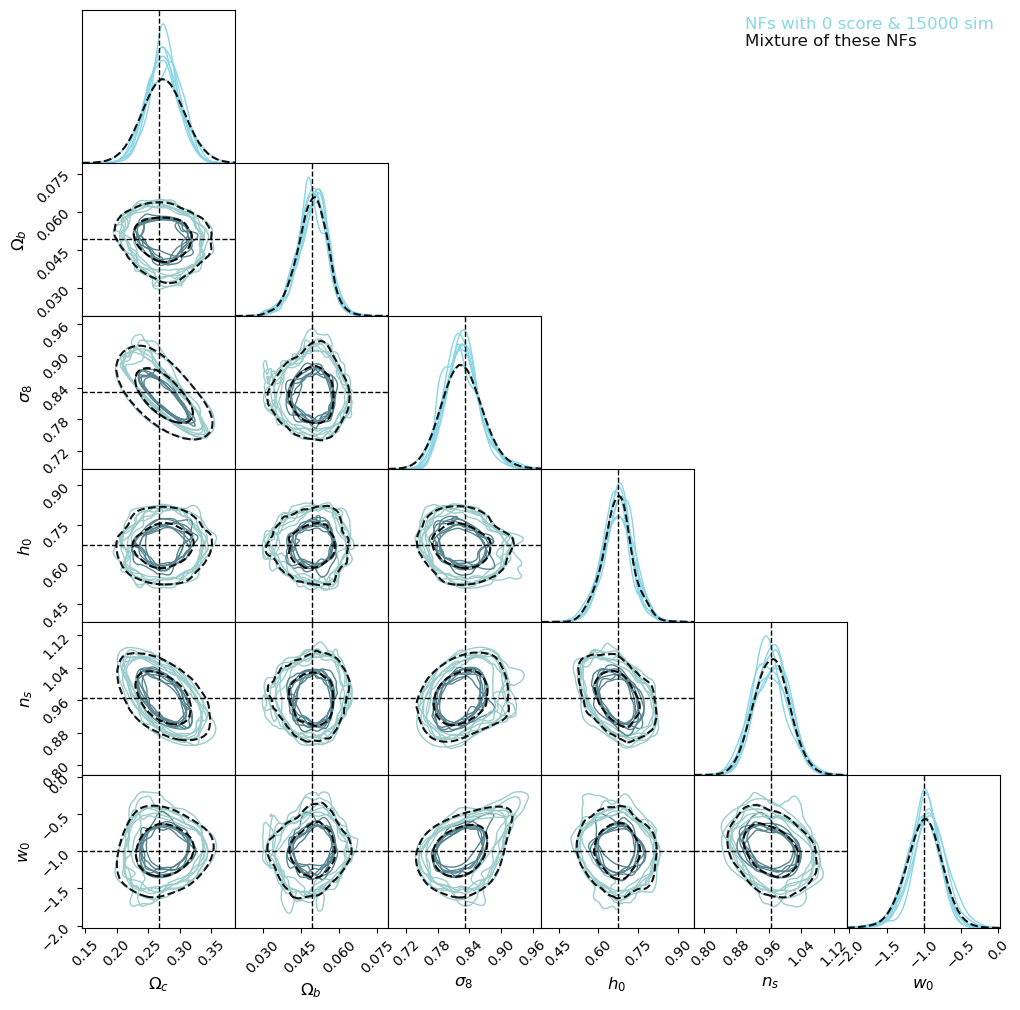

In [27]:
score = 0
nb_sim = 15_000

plt.figure()
c = ChainConsumer()

store_posteriors_sample = []
store_posteriors_params = []
for seed in seed_store:

    new_table = metric_deep_ensemble.loc[
        (metric_deep_ensemble['activ_fun'] == activ_fun)  & 
        (metric_deep_ensemble['lr_schedule'] == lr_schedule) &
        (metric_deep_ensemble['total_steps'] == total_steps)  & 
        (metric_deep_ensemble['score_weight'] == score)  & 
        (metric_deep_ensemble['n_flow_layers'] == n_flow_layers)  & 
        (metric_deep_ensemble['n_bijector_layers'] == n_bijector_layers) & 
        (metric_deep_ensemble['nb_simulations'] == nb_sim) &
        (metric_deep_ensemble['seed'] == seed)
    ]

    exp_id = list(new_table['experiment_id'])[0]
    path1 = './results/{}/posteriors_sample.npy'.format(str(exp_id))
    path2 = './results/{}/save_params/params_ode_flow.pkl'.format(str(exp_id))
    # if os.path.isfile(path):
    posterior_sample = np.load(path1)
    posterior_params = np.load(path2, allow_pickle=True)
    store_posteriors_sample.append(posterior_sample)
    store_posteriors_params.append(posterior_params)

    c.add_chain(
        posterior_sample,
        parameters=params_name,
        name='NFs with {} score & {} sim'.format(score, nb_sim),
        shade_alpha = 0.2,
        color = color[4]
    )


posterior, weight, cat_dict = get_sample_from_DE(
    store_posteriors_params, 
    store_posteriors_sample,
    dataset.item()['theta'][:m],
    dataset.item()['y'][:m],
    n
)

c.add_chain(
    posterior, 
    parameters=params_name, 
    name='Mixture of these NFs', 
    shade_alpha = 0.2, 
    color = color[5], 
    linewidth=1.5,
    linestyle = '--'
)

fig = c.plotter.plot(
    figsize=1.2,
    truth=truth,
    extents=[[t - 5 * np.std(ref_posterior[:,i]), 
              t + 5 * np.std(ref_posterior[:,i])] for i,t in enumerate(truth)]
)


cat = cat_samples = tfd.Categorical(probs=weight)
logp = get_logprob_from_DE(store_posteriors_params, dataset.item()['theta'][:m], dataset.item()['y'][:m], cat)

print('negative log prob: ', - logp.mean())

negative log prob:  29.49774


<Figure size 1500x800 with 0 Axes>

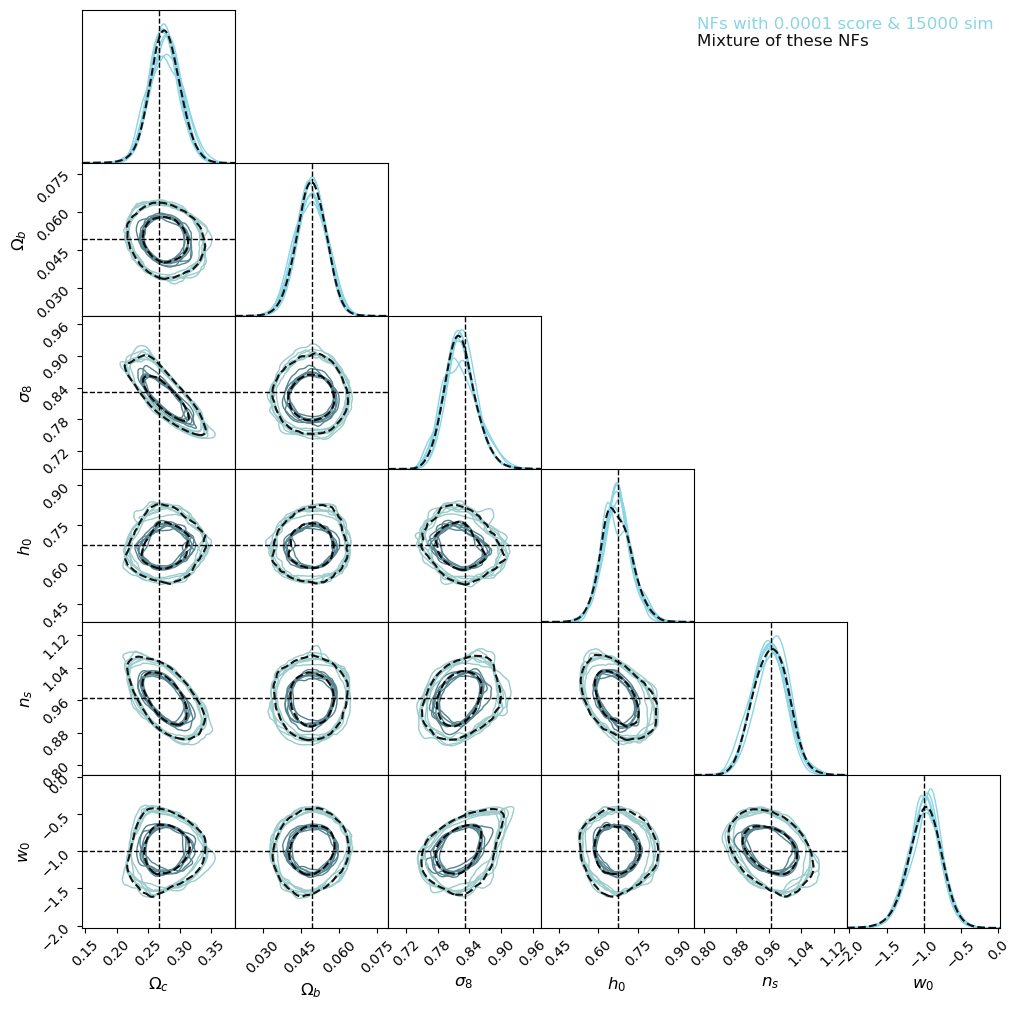

In [28]:
score = 1e-4
nb_sim = 15_000

plt.figure()
c = ChainConsumer()

store_posteriors_sample = []
store_posteriors_params = []
for seed in seed_store:

    new_table = metric_deep_ensemble.loc[
        (metric_deep_ensemble['activ_fun'] == activ_fun)  & 
        (metric_deep_ensemble['lr_schedule'] == lr_schedule) &
        (metric_deep_ensemble['total_steps'] == total_steps)  & 
        (metric_deep_ensemble['score_weight'] == score)  & 
        (metric_deep_ensemble['n_flow_layers'] == n_flow_layers)  & 
        (metric_deep_ensemble['n_bijector_layers'] == n_bijector_layers) & 
        (metric_deep_ensemble['nb_simulations'] == nb_sim) &
        (metric_deep_ensemble['seed'] == seed)
    ]

    exp_id = list(new_table['experiment_id'])[0]
    path1 = './results/{}/posteriors_sample.npy'.format(str(exp_id))
    path2 = './results/{}/save_params/params_ode_flow.pkl'.format(str(exp_id))
    # if os.path.isfile(path):
    posterior_sample = np.load(path1)
    posterior_params = np.load(path2, allow_pickle=True)
    store_posteriors_sample.append(posterior_sample)
    store_posteriors_params.append(posterior_params)

    c.add_chain(
        posterior_sample,
        parameters=params_name,
        name='NFs with {} score & {} sim'.format(score, nb_sim),
        shade_alpha = 0.2,
        color = color[4]
    )


posterior, weight, cat_dict = get_sample_from_DE(
    store_posteriors_params, 
    store_posteriors_sample,
    dataset.item()['theta'][:m],
    dataset.item()['y'][:m],
    n
)

c.add_chain(
    posterior, 
    parameters=params_name, 
    name='Mixture of these NFs', 
    shade_alpha = 0.2, 
    color = color[5], 
    linewidth=1.5,
    linestyle = '--'
)

fig = c.plotter.plot(
    figsize=1.2,
    truth=truth,
    extents=[[t - 5 * np.std(ref_posterior[:,i]), 
              t + 5 * np.std(ref_posterior[:,i])] for i,t in enumerate(truth)]
)


cat = cat_samples = tfd.Categorical(probs=weight)
logp = get_logprob_from_DE(store_posteriors_params, dataset.item()['theta'][:m], dataset.item()['y'][:m], cat)

print('negative log prob: ', - logp.mean())

/tmp/ipykernel_226849/3284320721.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 1500x800 with 0 Axes>

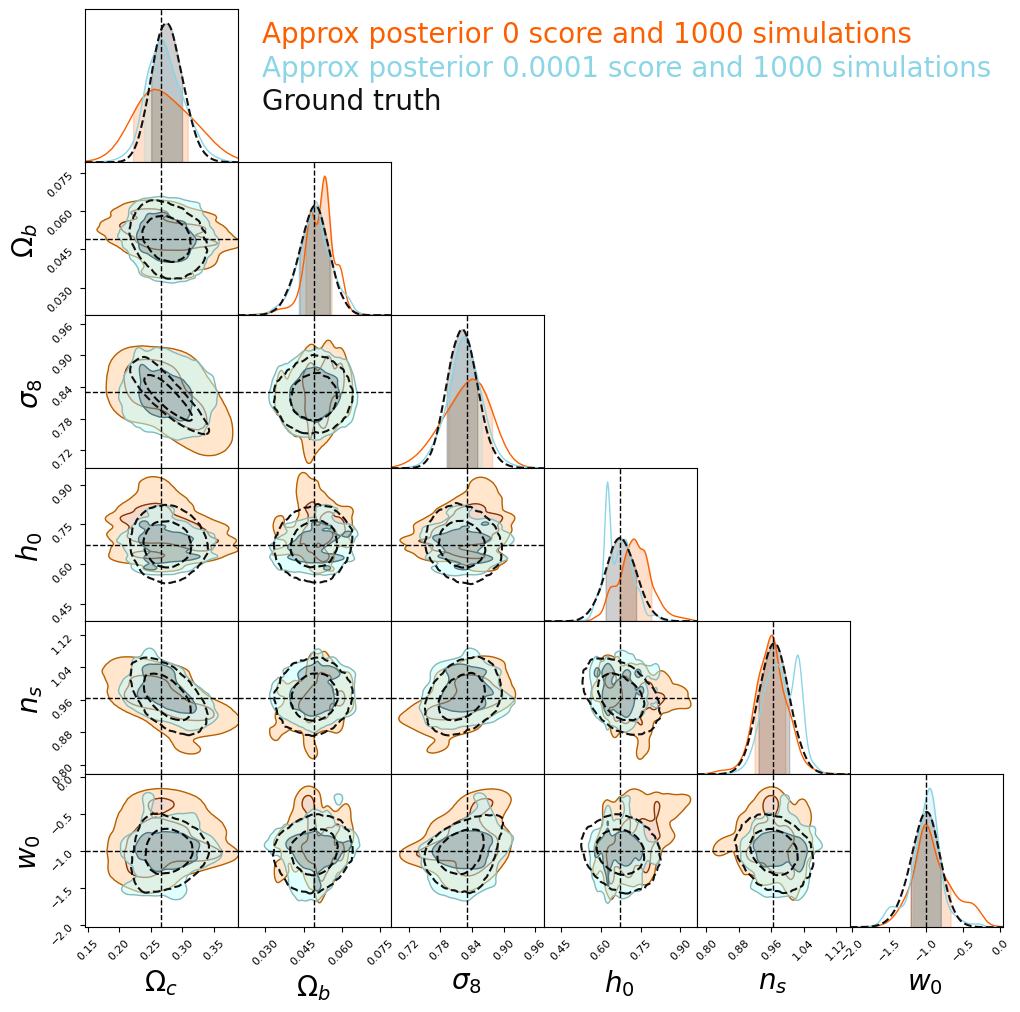

<Figure size 1500x800 with 0 Axes>

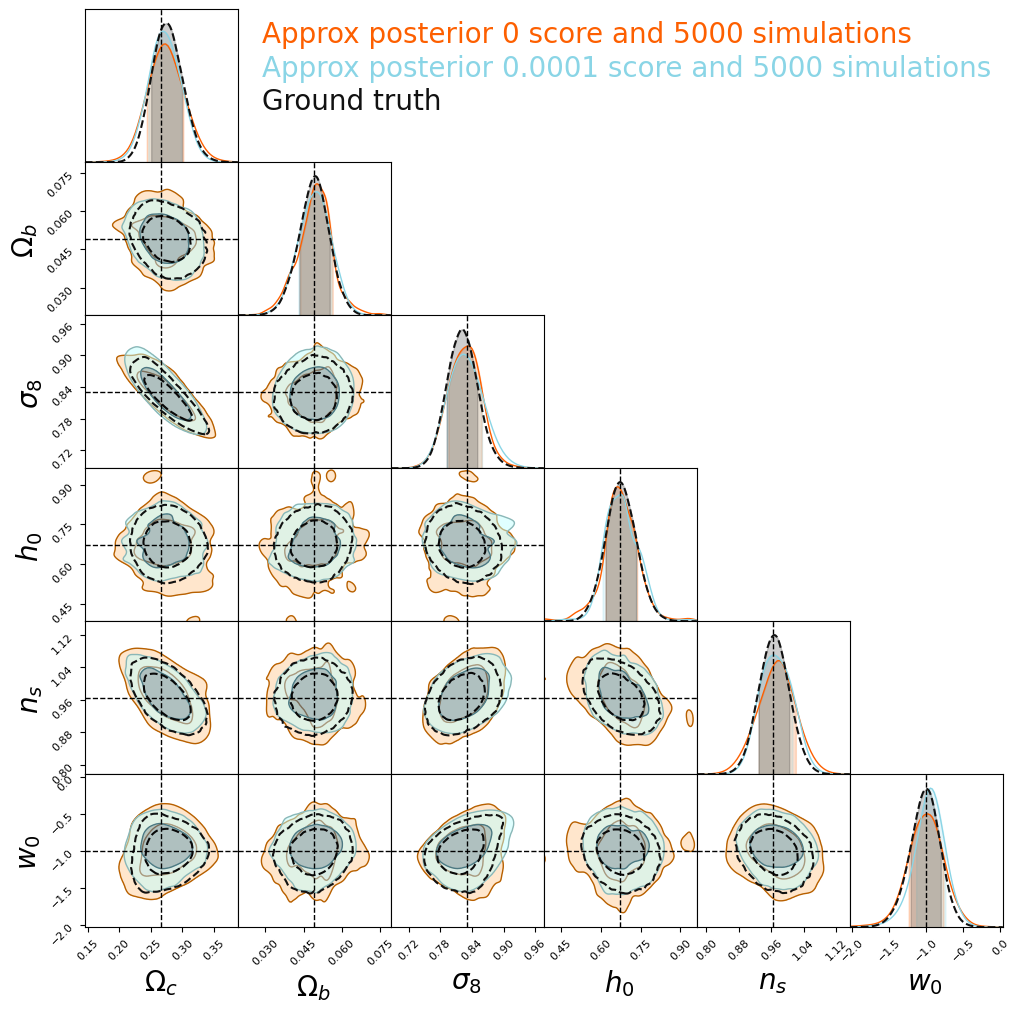

<Figure size 1500x800 with 0 Axes>

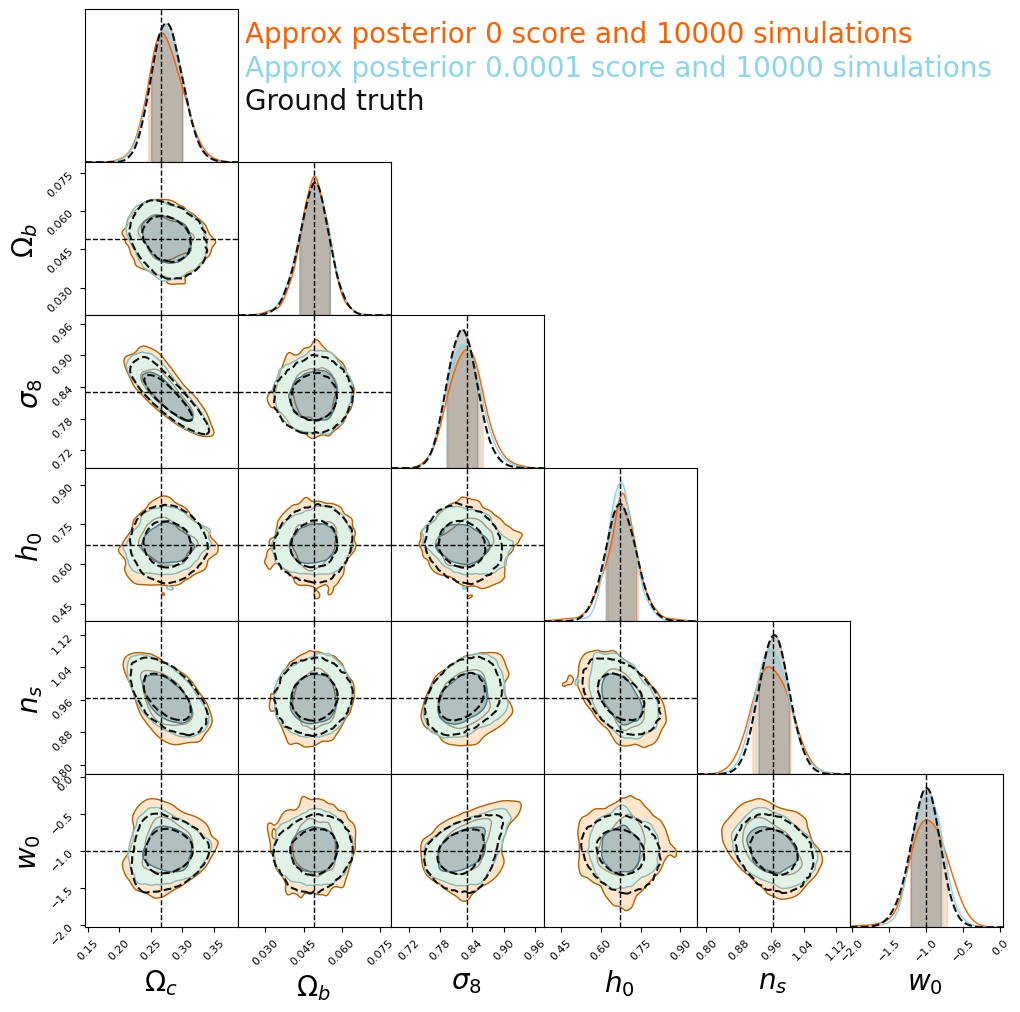

<Figure size 1500x800 with 0 Axes>

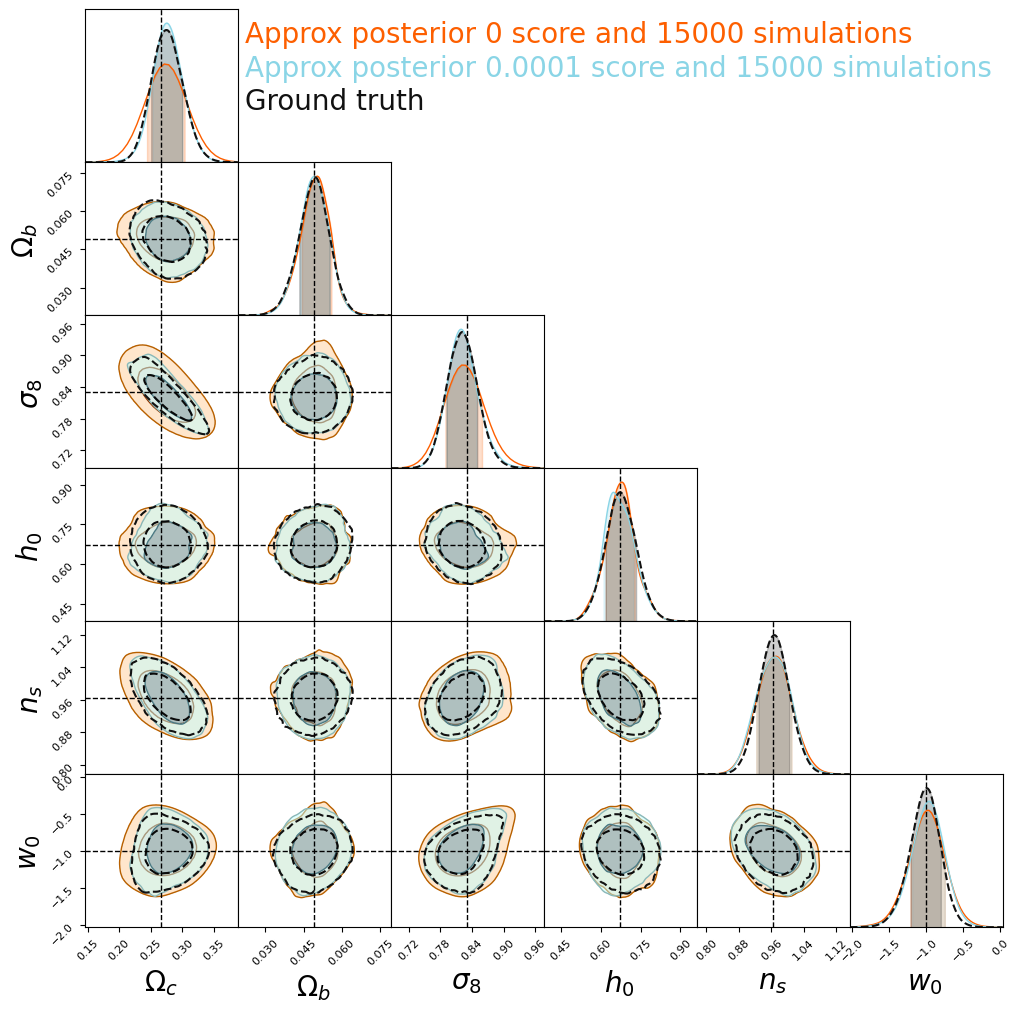

<Figure size 1500x800 with 0 Axes>

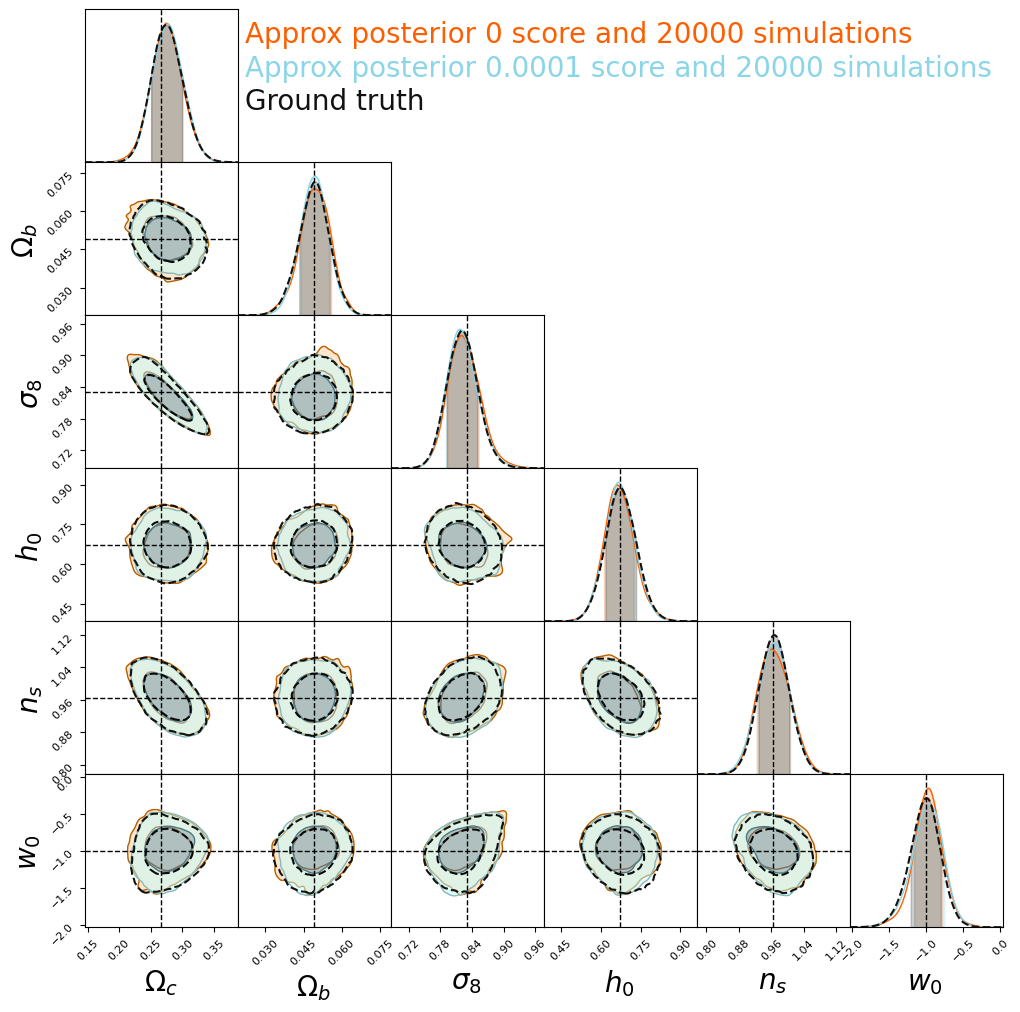

<Figure size 1500x800 with 0 Axes>

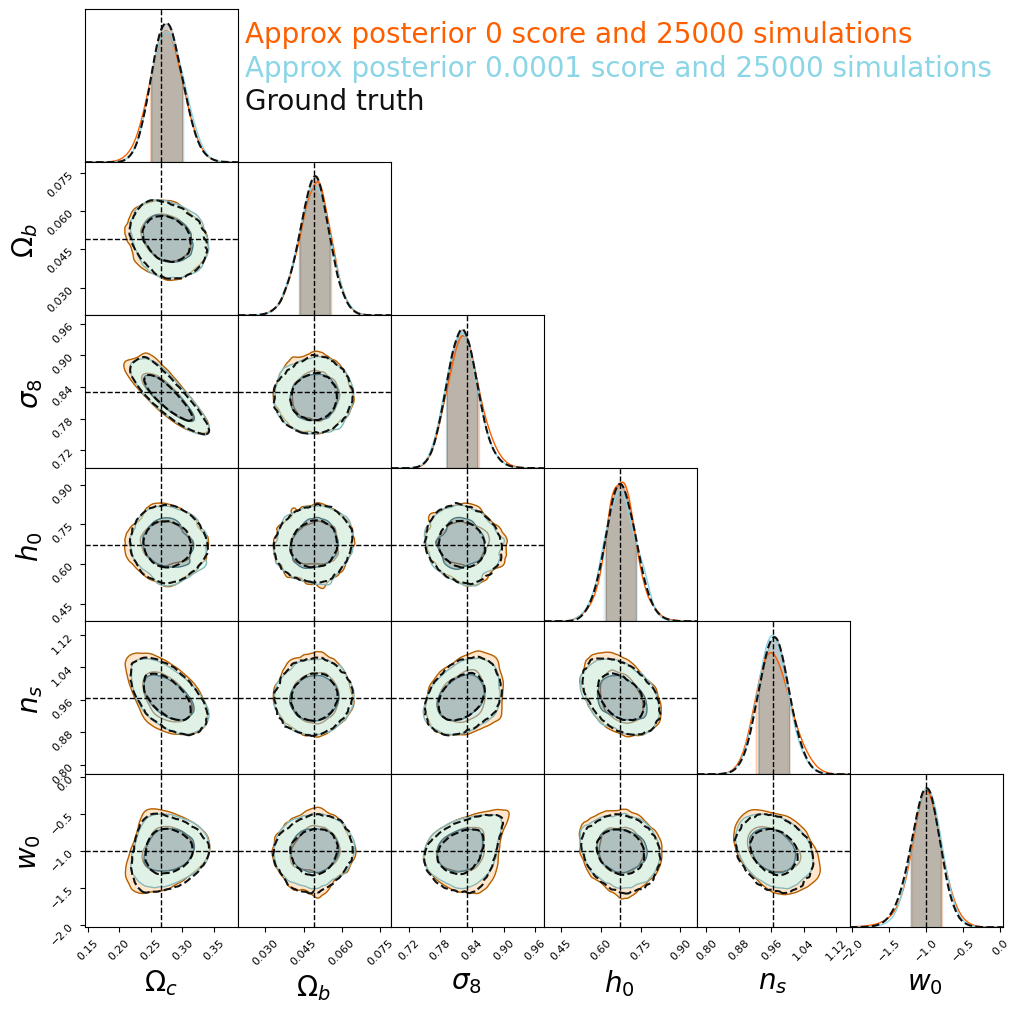

<Figure size 1500x800 with 0 Axes>

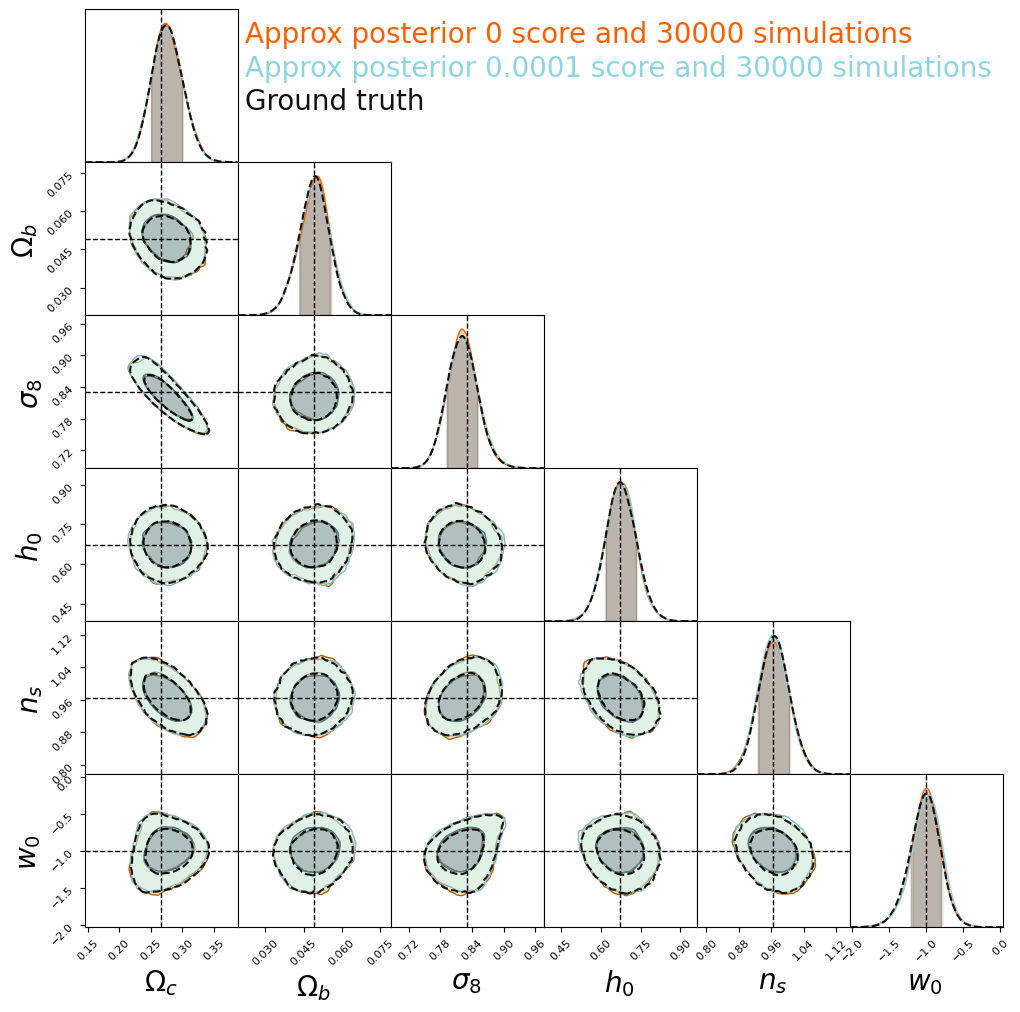

<Figure size 1500x800 with 0 Axes>

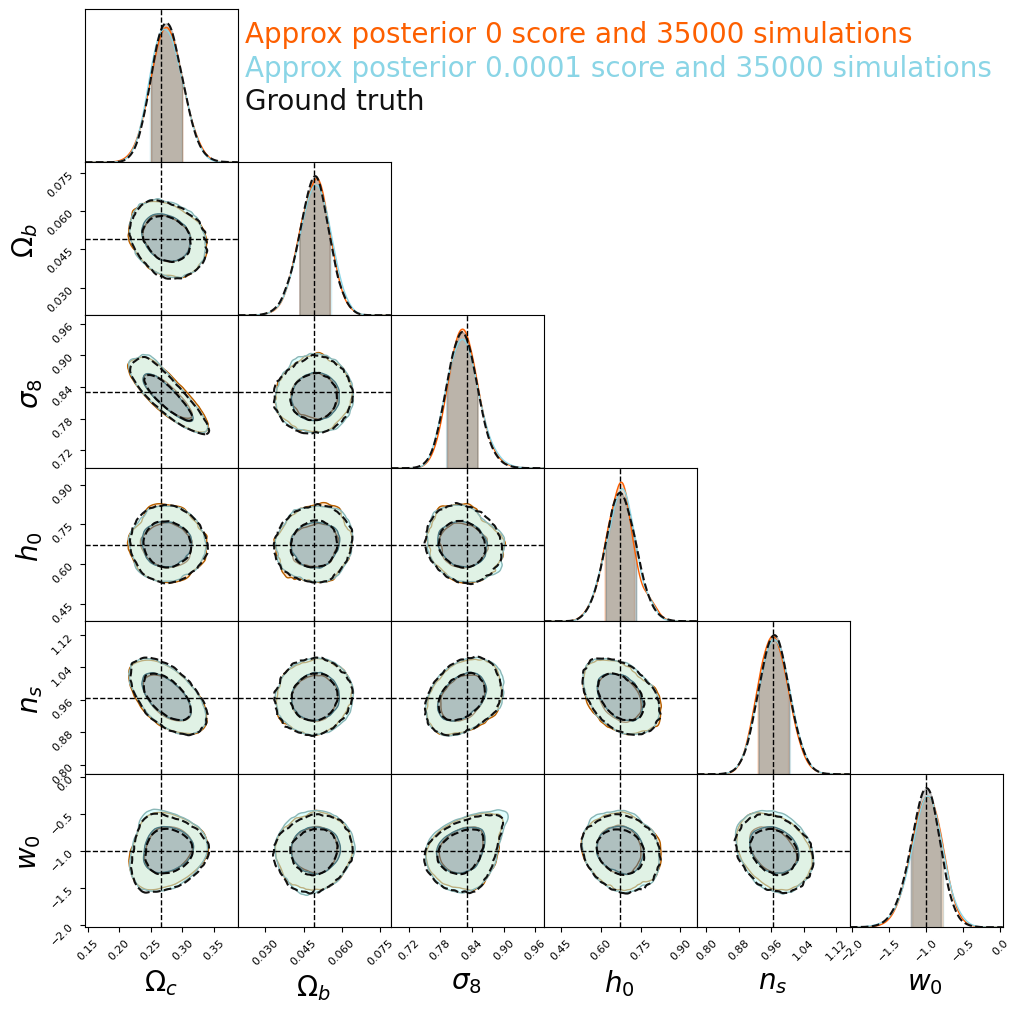

<Figure size 1500x800 with 0 Axes>

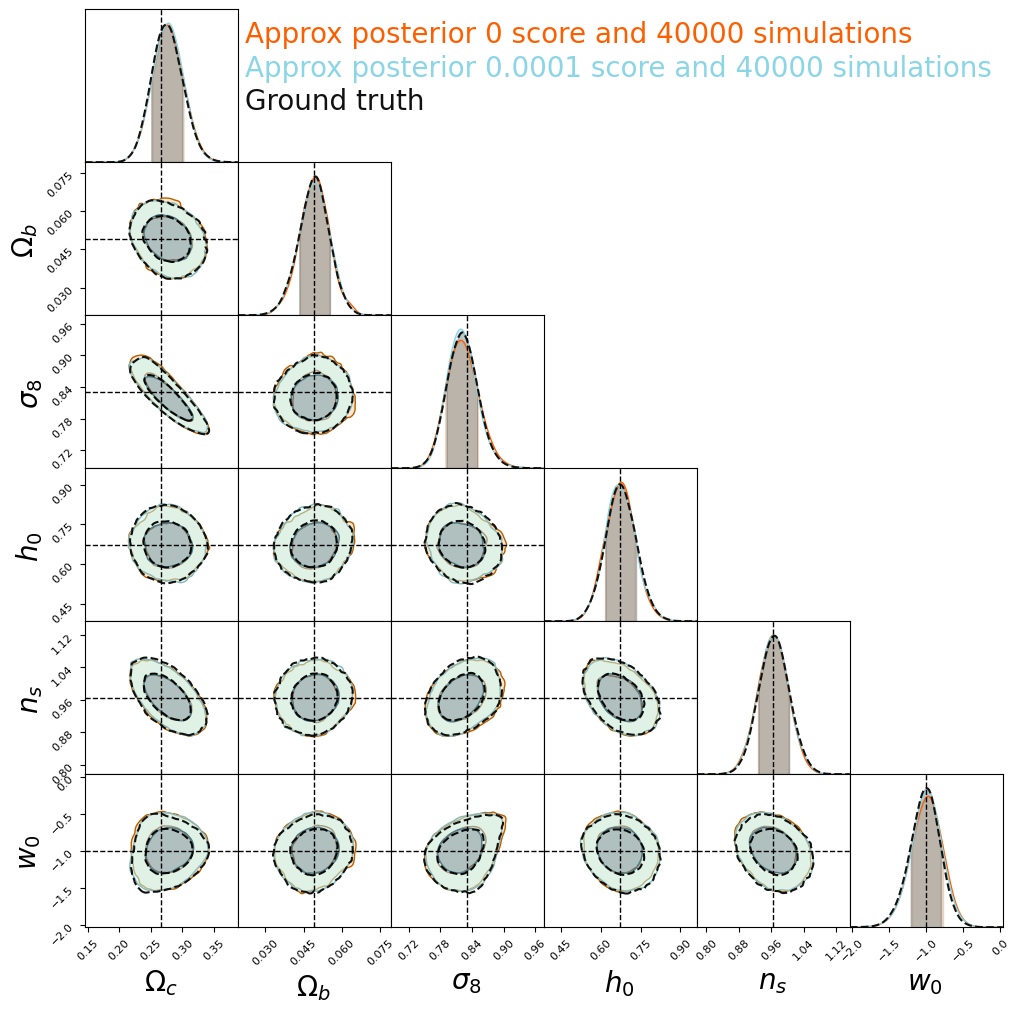

<Figure size 1500x800 with 0 Axes>

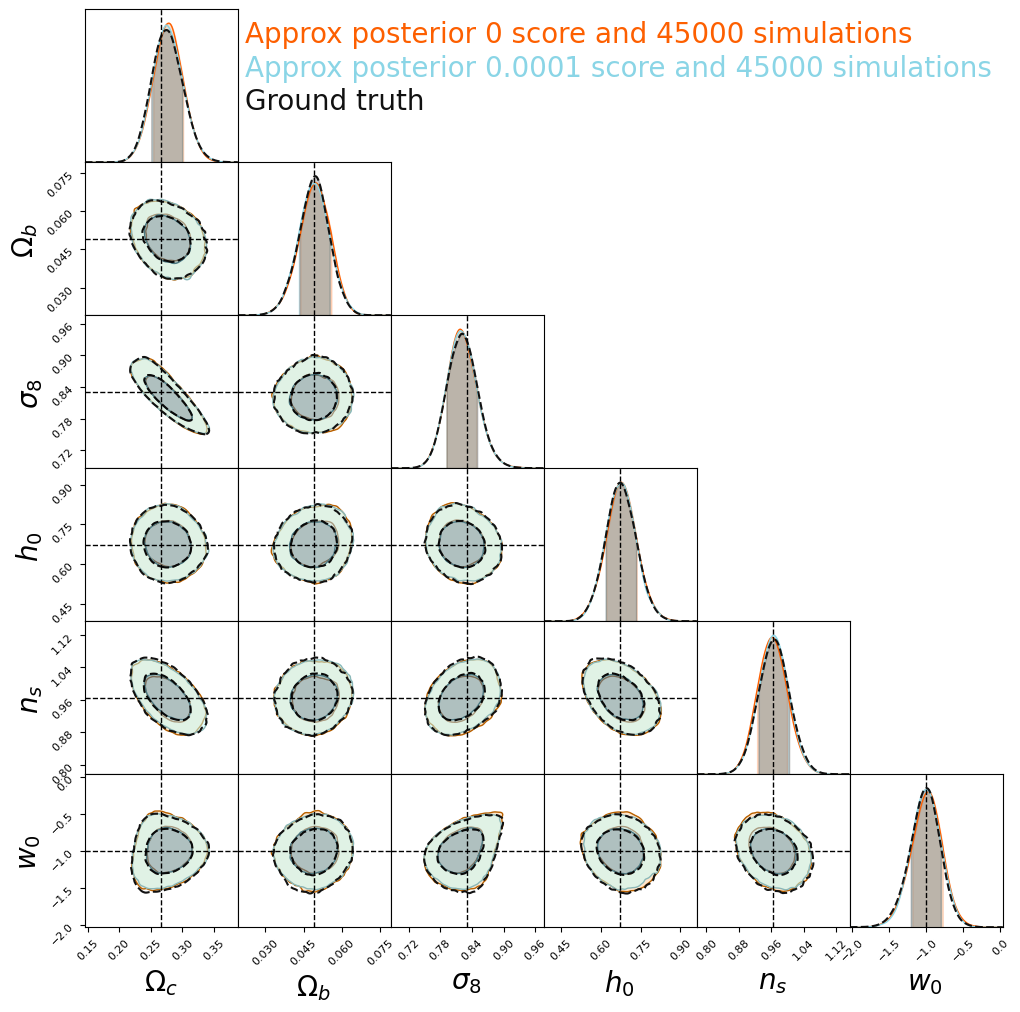

<Figure size 1500x800 with 0 Axes>

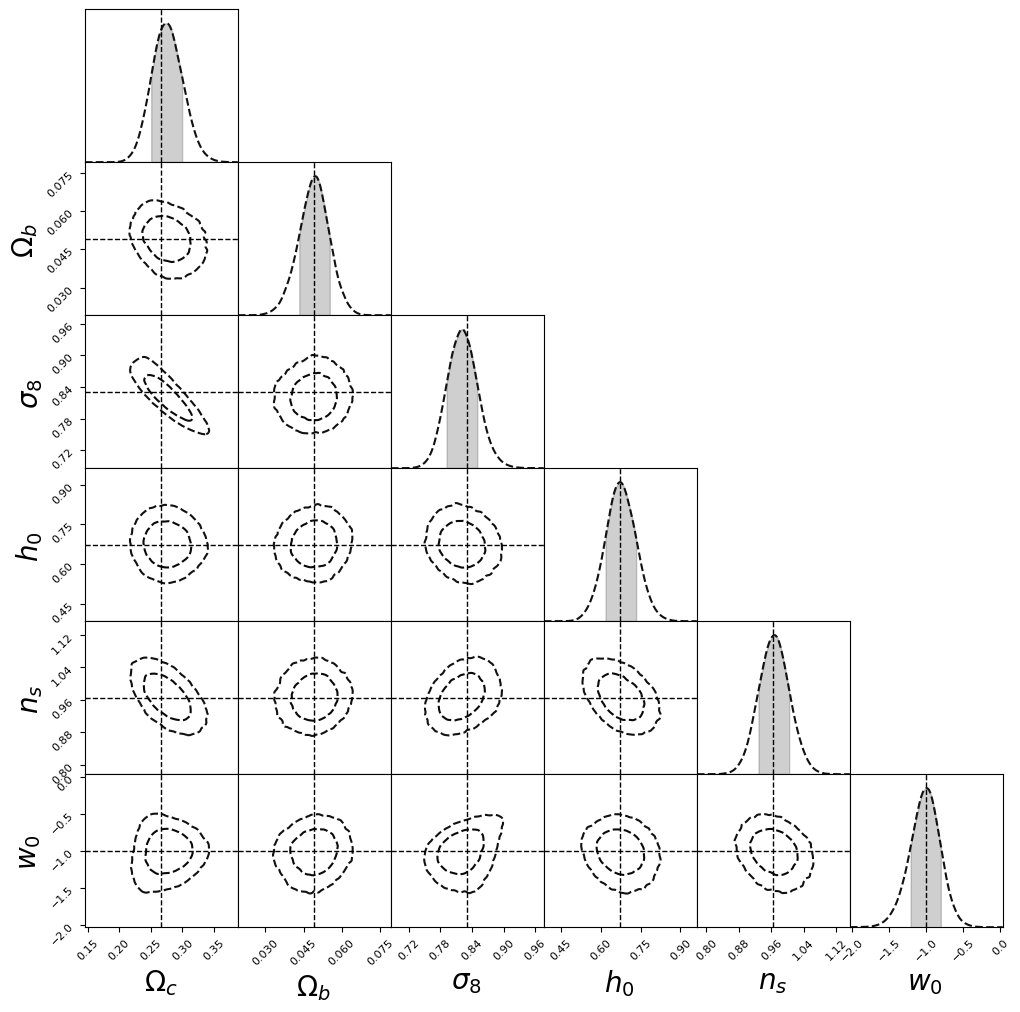

<Figure size 1500x800 with 0 Axes>

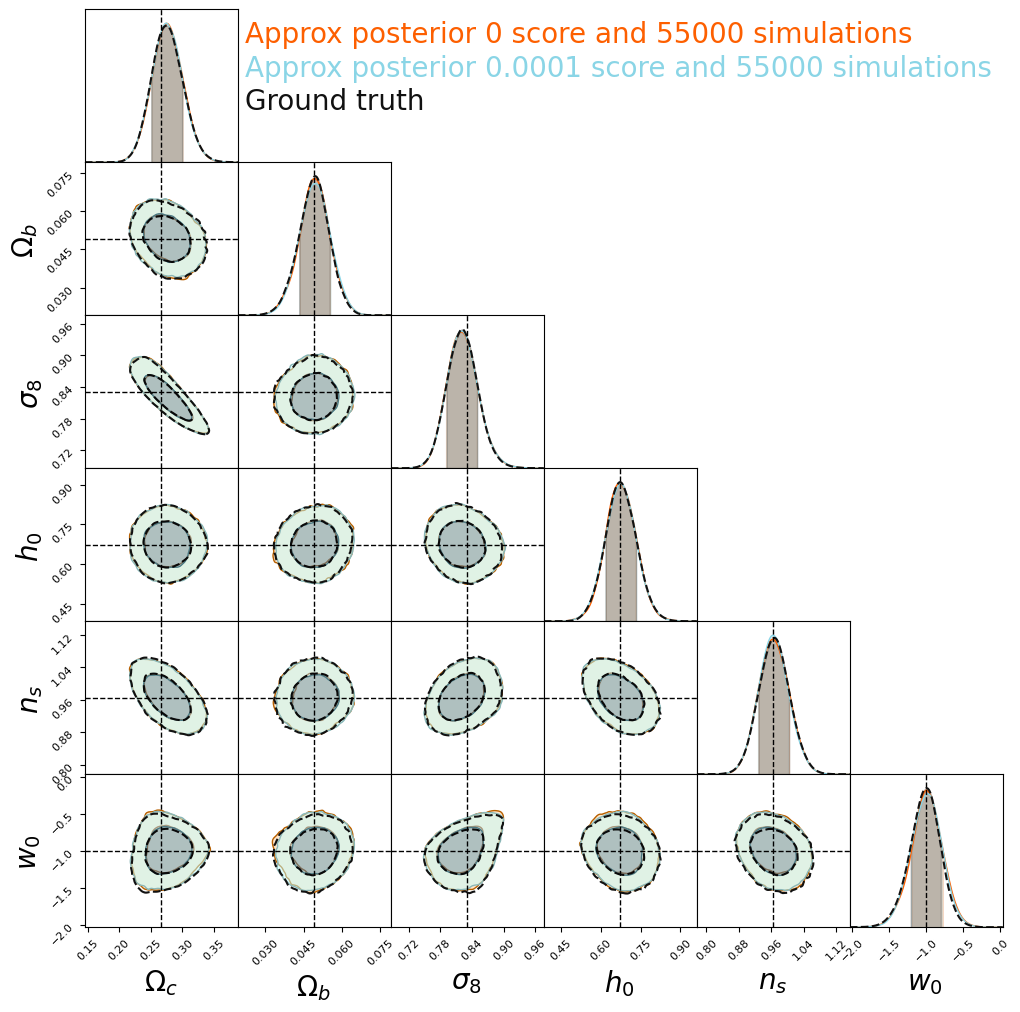

<Figure size 1500x800 with 0 Axes>

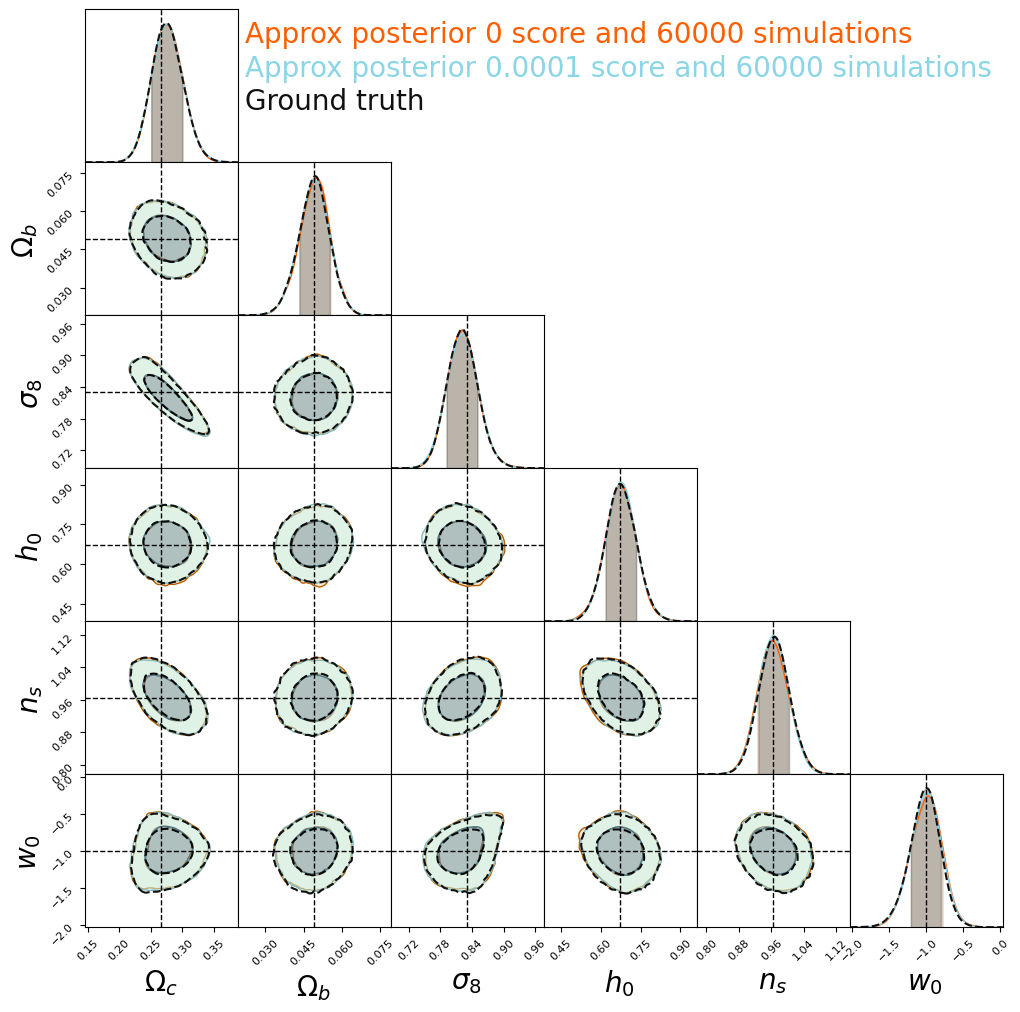

<Figure size 1500x800 with 0 Axes>

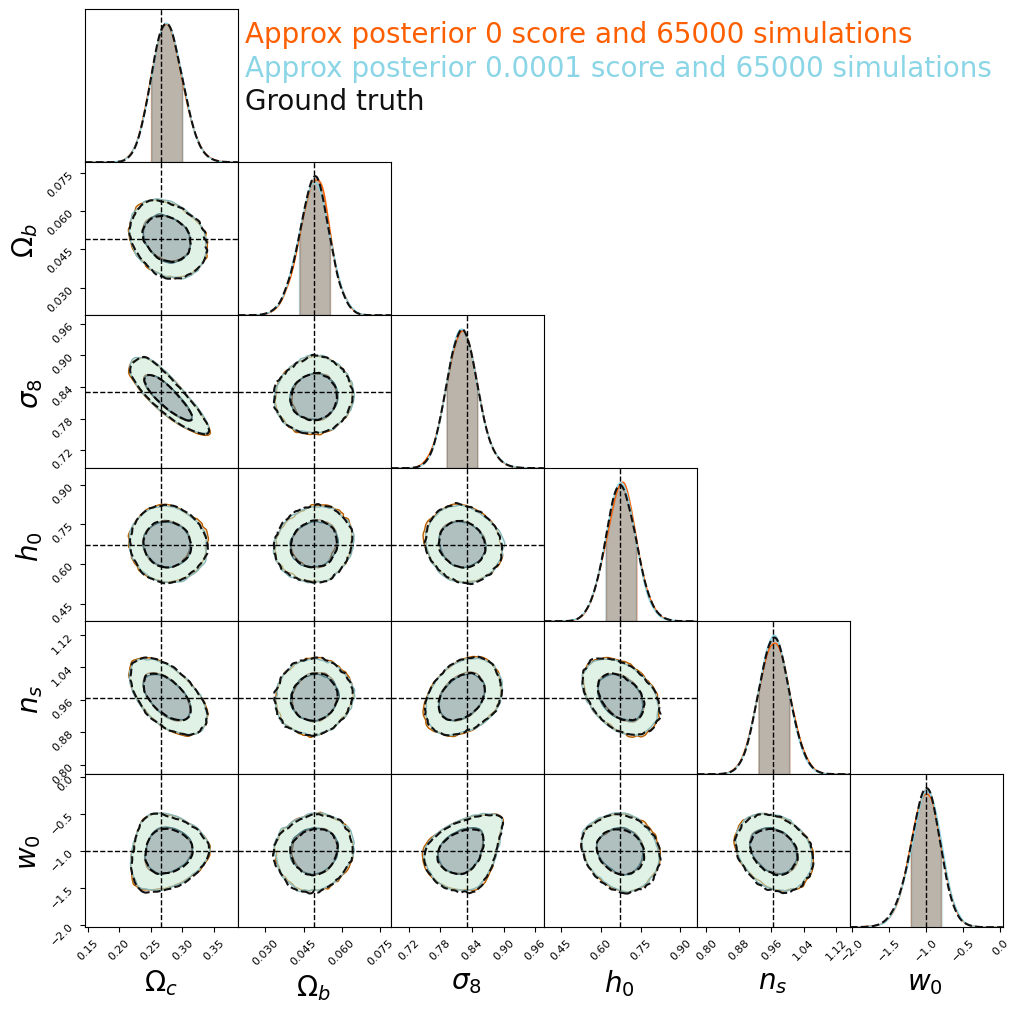

<Figure size 1500x800 with 0 Axes>

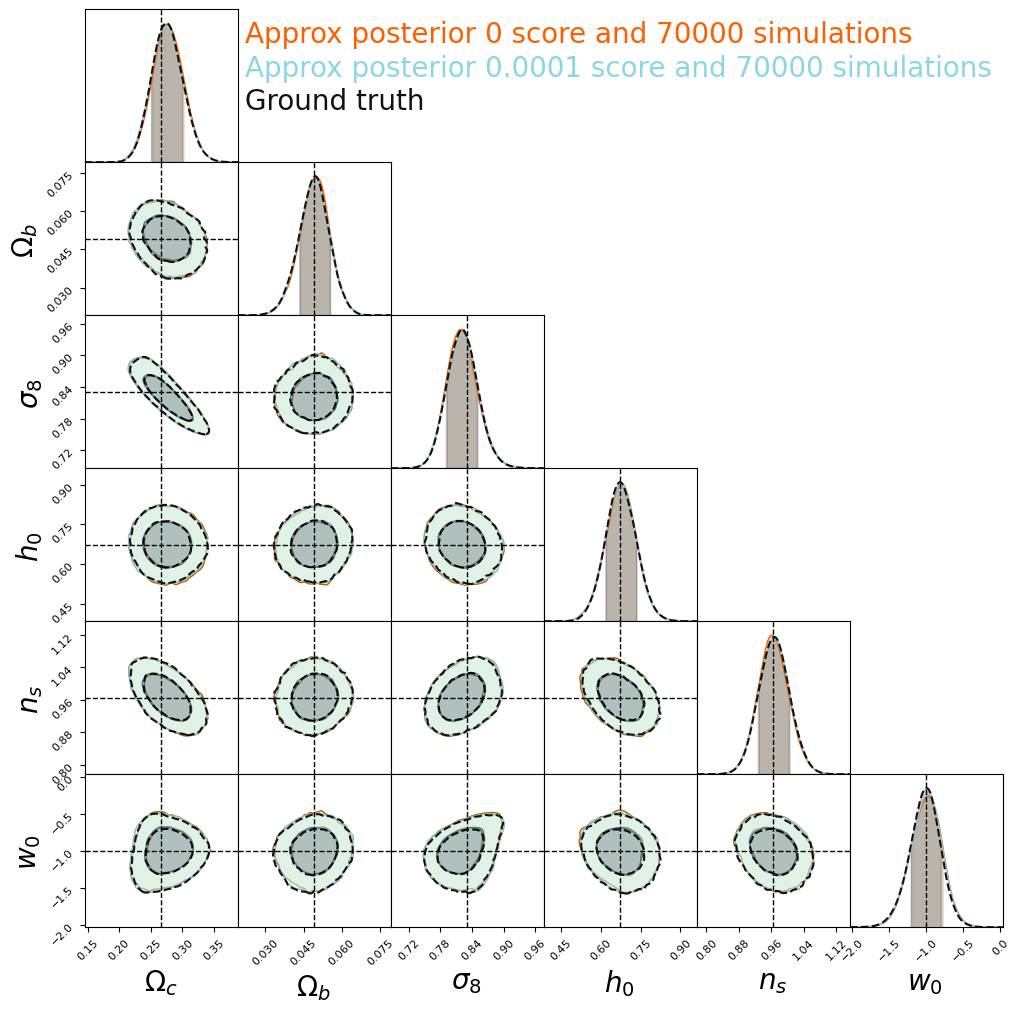

<Figure size 1500x800 with 0 Axes>

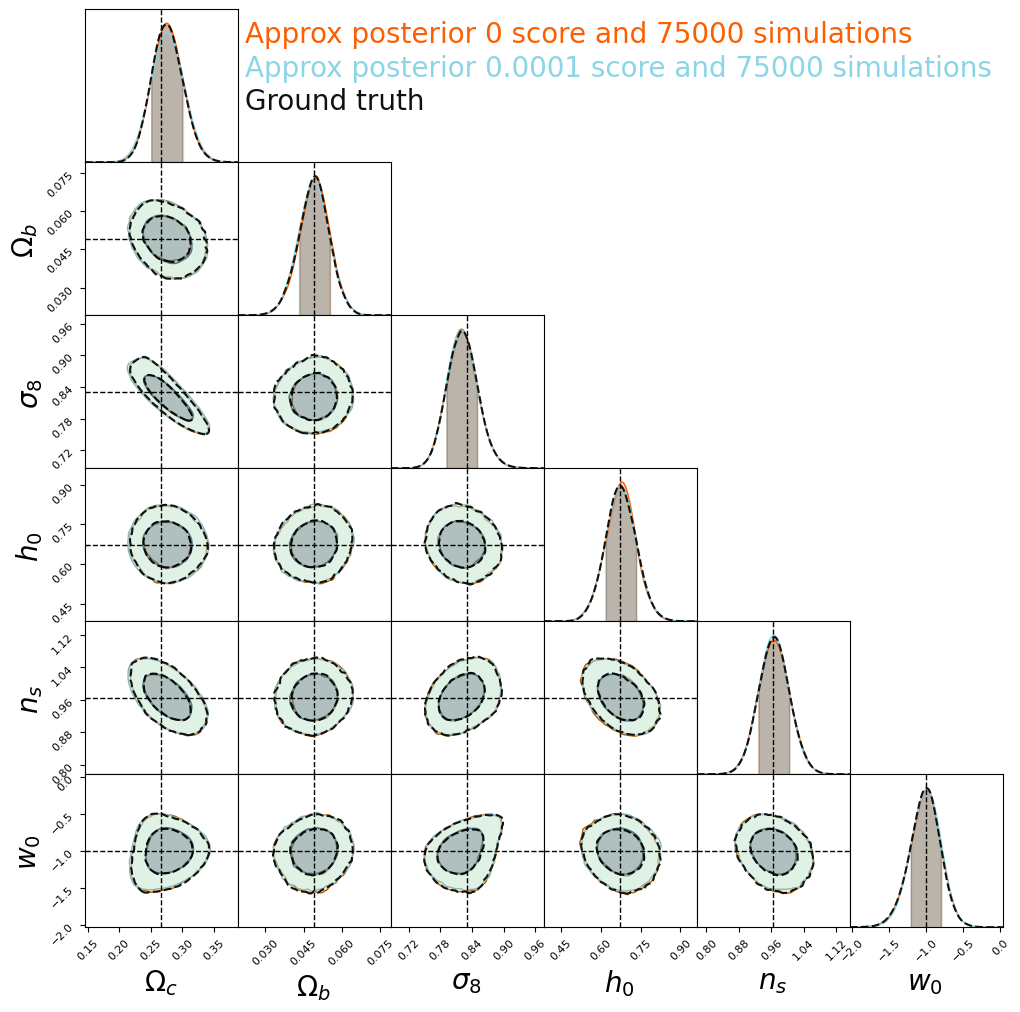

<Figure size 1500x800 with 0 Axes>

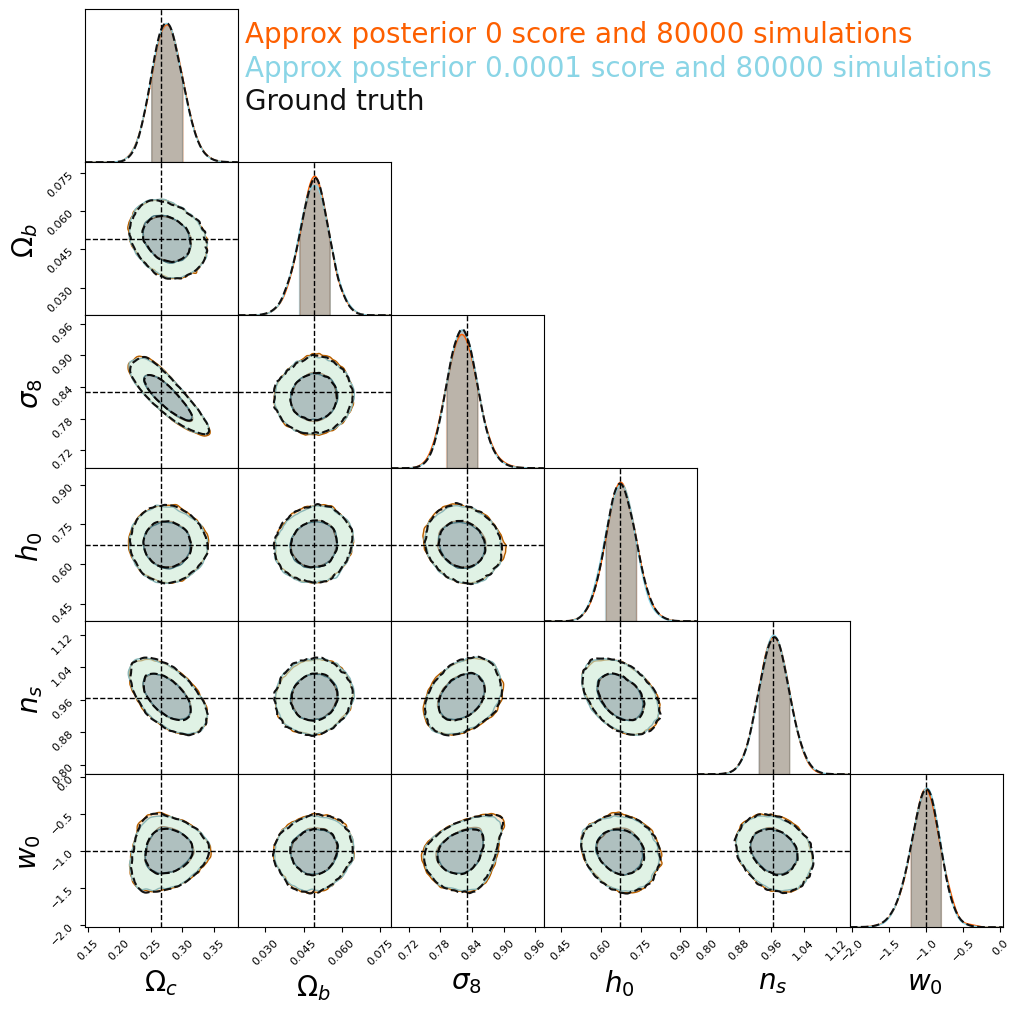

<Figure size 1500x800 with 0 Axes>

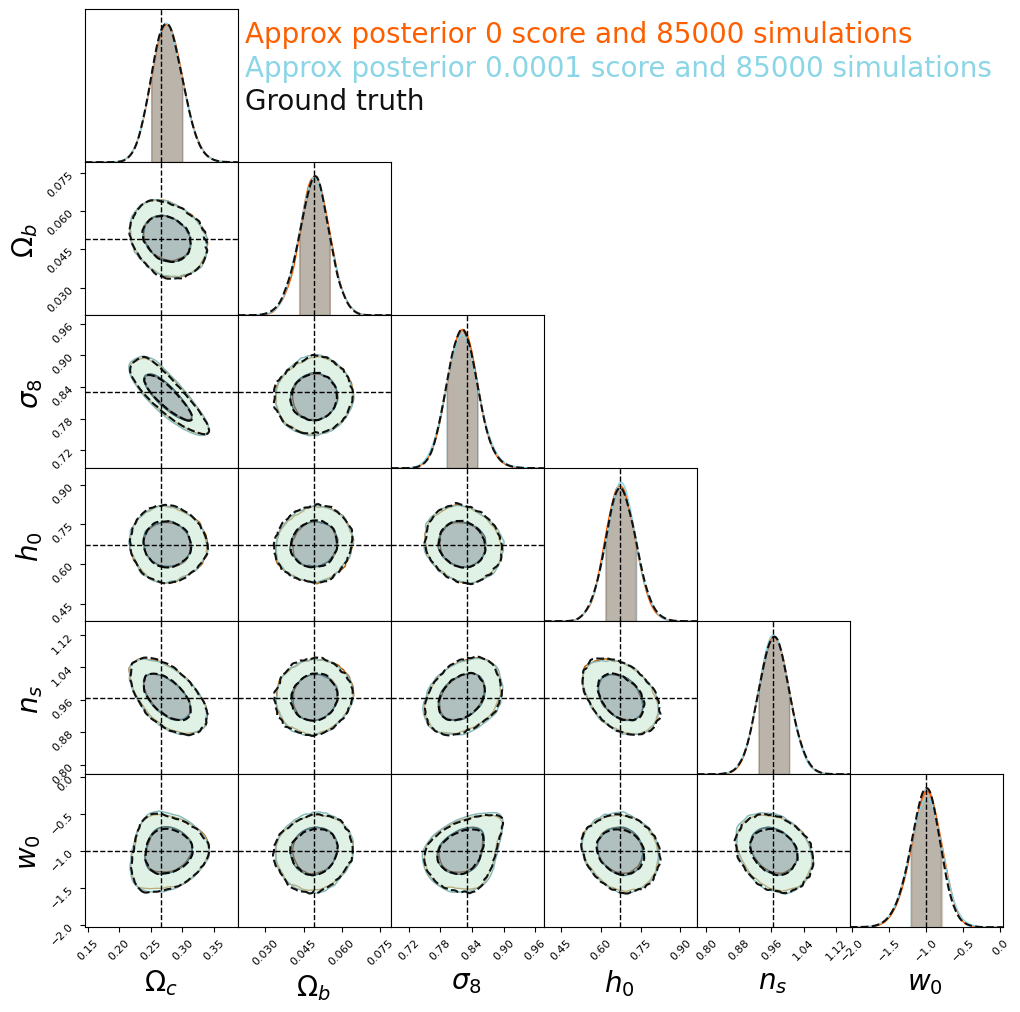

<Figure size 1500x800 with 0 Axes>

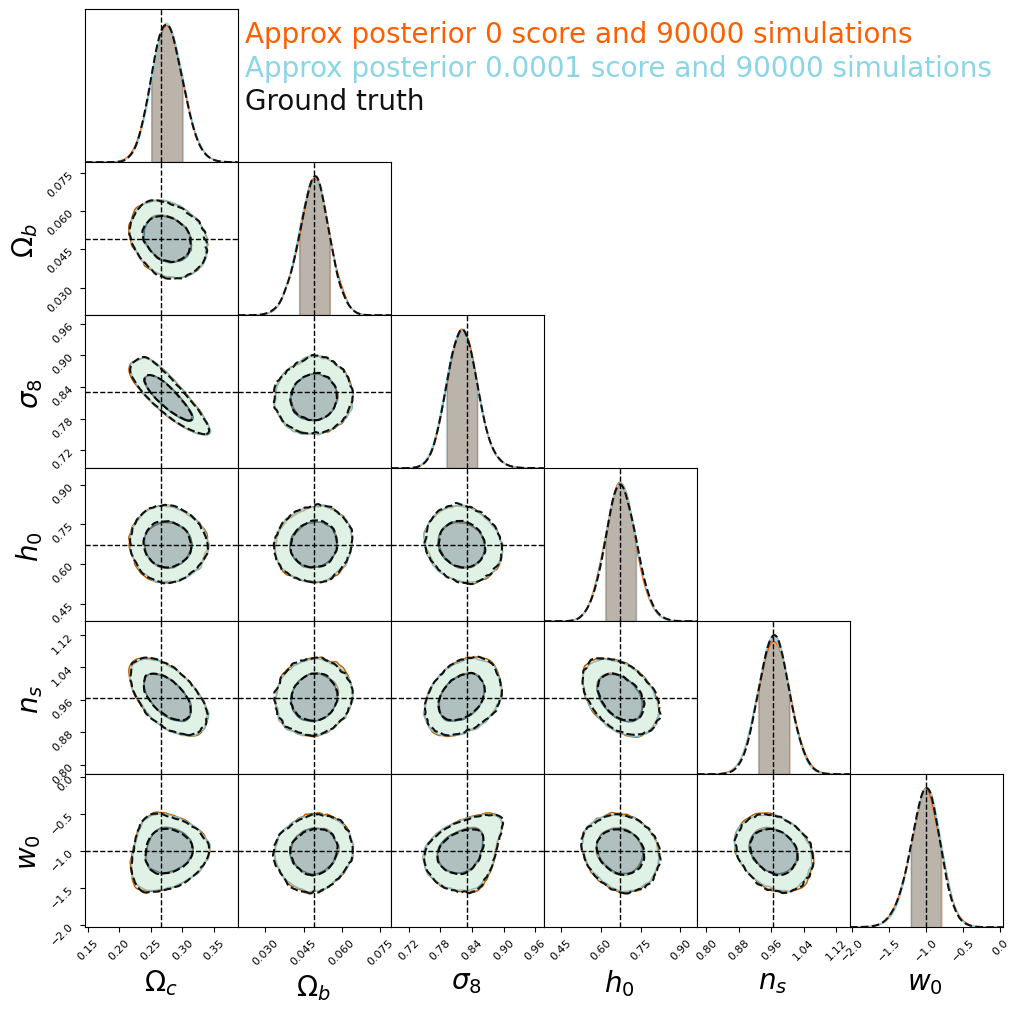

<Figure size 1500x800 with 0 Axes>

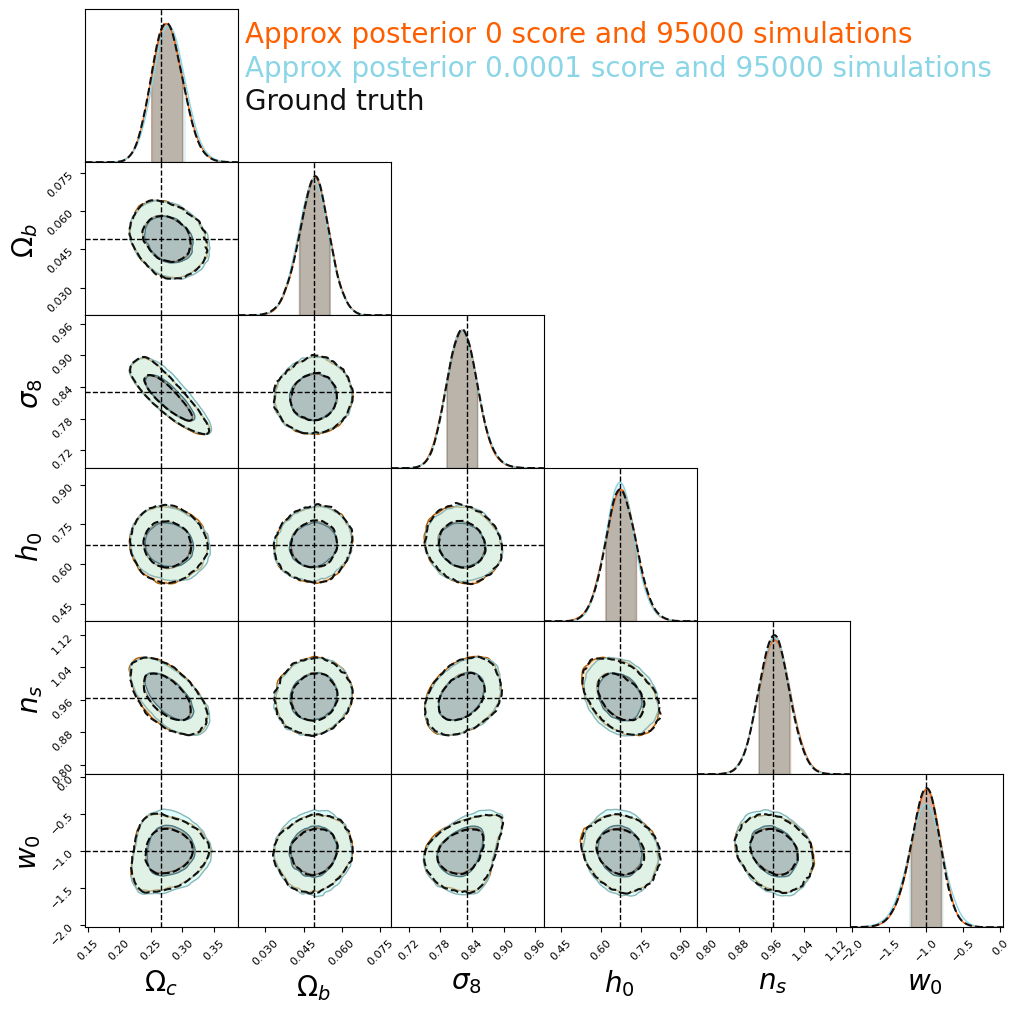

<Figure size 1500x800 with 0 Axes>

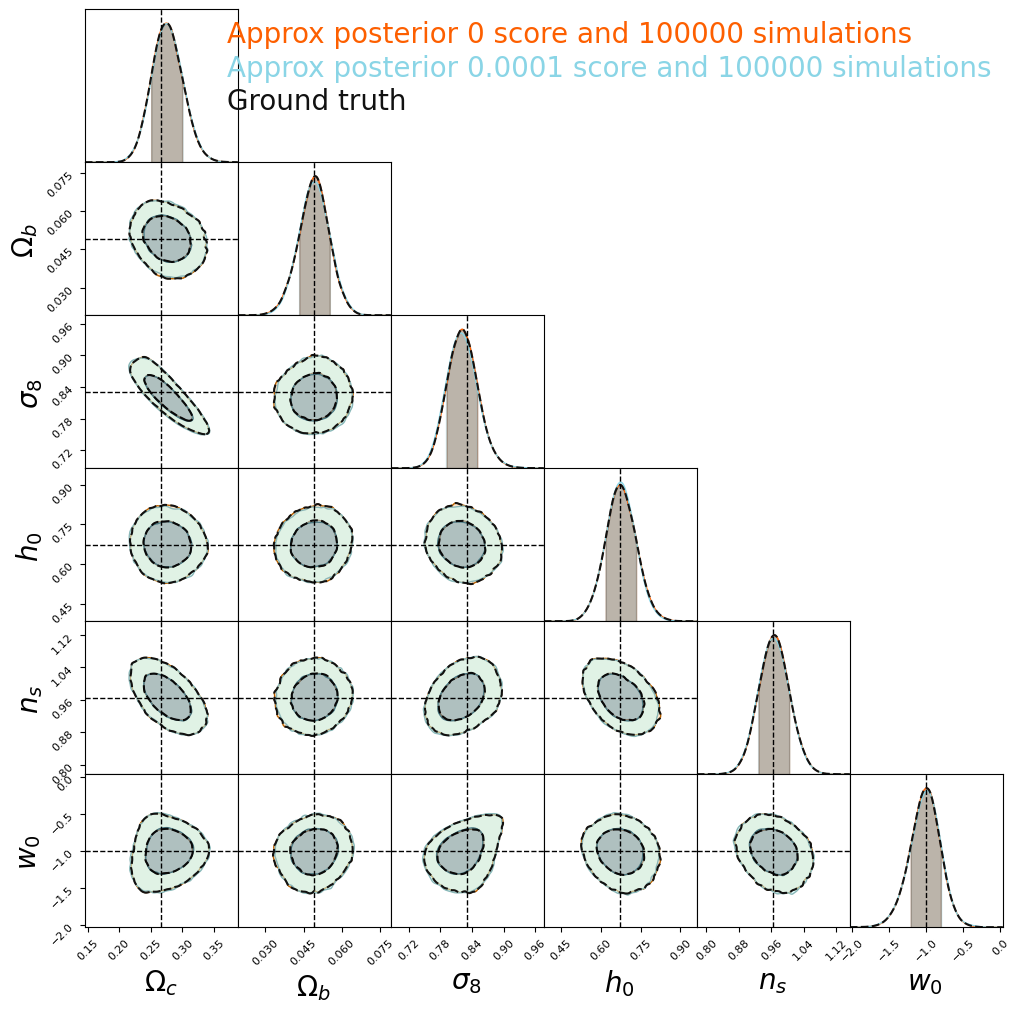

In [30]:
colmap = ['#FD5F00', '#8AD5E6']
shade =[0.2,0.5]
tmp = list(range(0, 101_000, 5000))
tmp[0] = 1000

for nb_simulations in tmp:
    plt.figure()
    c = ChainConsumer()
    i = 0
    for score in [0, 1e-4]:

        store_posteriors_sample_without_score = []
        store_posteriors_params_without_score = []
        for seed in seed_store:

            new_table = metric_deep_ensemble.loc[
                (metric_deep_ensemble['activ_fun'] == activ_fun)  & 
                (metric_deep_ensemble['lr_schedule'] == lr_schedule) &
                (metric_deep_ensemble['total_steps'] == total_steps)  & 
                (metric_deep_ensemble['score_weight'] == score)  & 
                (metric_deep_ensemble['n_flow_layers'] == n_flow_layers)  & 
                (metric_deep_ensemble['n_bijector_layers'] == n_bijector_layers) & 
                (metric_deep_ensemble['nb_simulations'] == nb_simulations) &
                (metric_deep_ensemble['seed'] == seed)
            ]
            
            if len(list(new_table['experiment_id'])) != 0:
                exp_id = list(new_table['experiment_id'])[0]
                path1 = './results/{}/posteriors_sample.npy'.format(str(exp_id))
                path2 = './results/{}/save_params/params_ode_flow.pkl'.format(str(exp_id))
                # if os.path.isfile(path):
                posterior_sample = np.load(path1)
                posterior_params = np.load(path2, allow_pickle=True)
                store_posteriors_sample_without_score.append(posterior_sample)
                store_posteriors_params_without_score.append(posterior_params)
                
        if len(list(new_table['experiment_id'])) != 0:    
            posterior_without_score, weight, cat_dict = get_sample_from_DE(
                store_posteriors_params_without_score, 
                store_posteriors_sample_without_score,
                dataset.item()['theta'][:m],
                dataset.item()['y'][:m],
                n
            )

            c.add_chain(
                posterior_without_score, 
                parameters=params_name, 
                name='Approx posterior {} score and {} simulations'.format(score, nb_simulations), 
                shade_alpha =shade[i], 
                color = colmap[i]
            )
        i+=1

    c.add_chain(
        ref_posterior, 
        parameters=params_name, 
        name='Ground truth', 
        linewidth=1.5,
        color = "#111111", 
        shade_alpha = 0, 
        linestyle = '--'
    )
    c.configure(legend_kwargs={"fontsize": 20}, tick_font_size=8, label_font_size=20)
    fig = c.plotter.plot(
        figsize=1.2, 
        truth=truth,
        extents=[[t - 5 * np.std(ref_posterior[:,i]), 
                  t + 5 * np.std(ref_posterior[:,i])] for i,t in enumerate(truth)]
    )
    plt.savefig('evol_contour_plot/comparison_plot_{}_simulations.pdf'.format(nb_simulations))

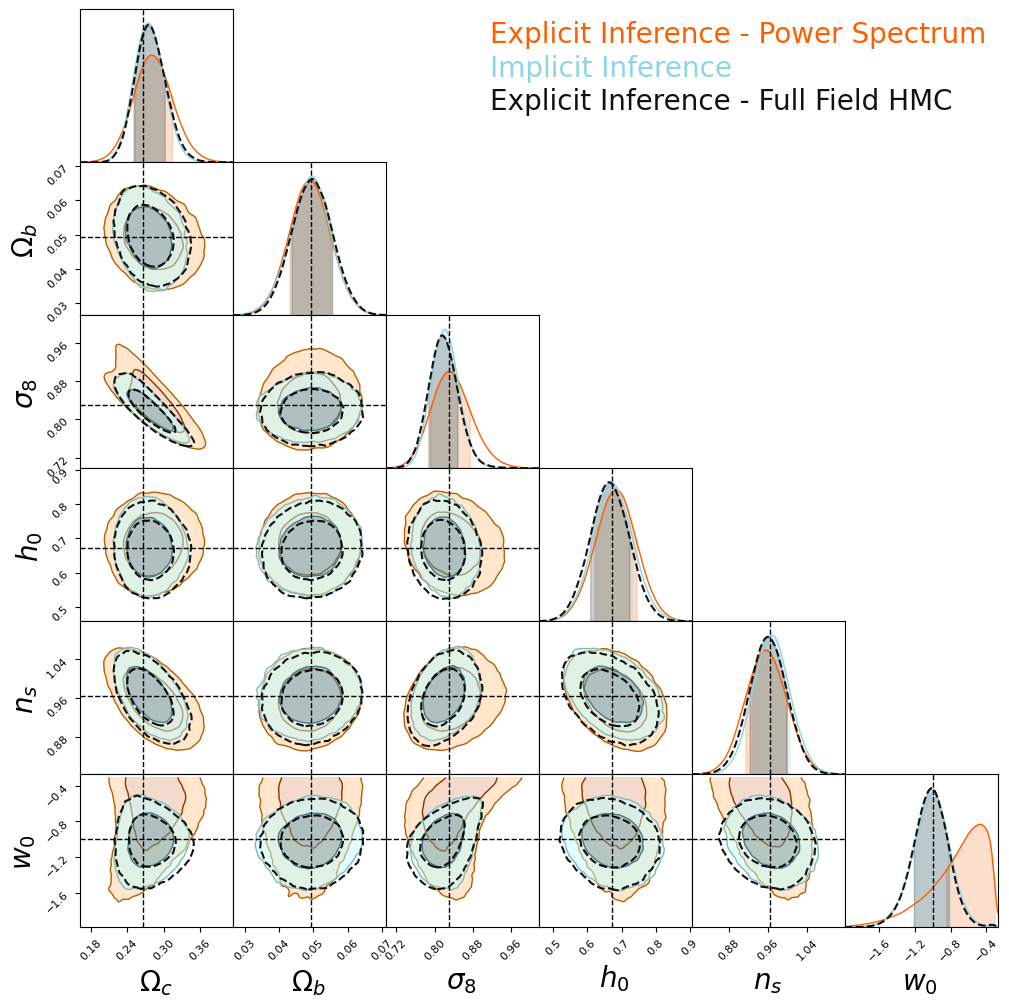

In [31]:
c = ChainConsumer()
c.add_chain(sample_ps, parameters=params_name, name='Explicit Inference - Power Spectrum', color = color[-1],  shade_alpha = 0.2)
c.add_chain(ref_posterior, parameters=params_name, name='Implicit Inference', color = color[4], shade_alpha = 0.5)
c.add_chain(sample_ff, parameters=params_name, name='Explicit Inference - Full Field HMC', linewidth=1.5, color = "#111111", shade_alpha = 0, linestyle = '--')
c.configure(legend_kwargs={"fontsize": 20}, tick_font_size=8, label_font_size=20)
fig = c.plotter.plot(figsize=1.2, truth=truth)

plt.savefig('compare_contour_plot.pdf', transparent=True)